# End-to-end multi class dog breed classification

This notebook builds an end to end multi-class image classifier using Tenserflow.

## 1. Problem
Identify the breed of dog, given the image.

## 2. Data
The data we're using is from Kaggle's Dog Breed Identification Problem: https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation
Multi Class Log Loss between the predicted probability and the observed target.

## 4. Features
* We're dealing with images ( unstructured data ), so we will be using deep learning.
* There are 120 different classes.
* There are 10,000+ images in train set and test set ( each ).

In [1]:
# unzip the data folder
# !unzip dog-breed-identification.zip

# Get our workspace ready

In [2]:
# import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd

print("Using tensorflow version: ", tf.__version__)
print("Using tensorflow hub version: ", hub.__version__)

print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

Using tensorflow version:  2.19.0
Using tensorflow hub version:  0.16.1
GPU available


## Getting our data ready ( Turning into sensors)

For all machine learning models, we have to turn our data into numerical representation. For this, we will be turning our data into tensors.

In [3]:
# load labels
labels_df = pd.read_csv("drive/MyDrive/dog-breed-identification/labels.csv")
labels_df.tail()
# labels_df.info()

,id,breed
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher
10221,fff43b07992508bc822f33d8ffd902ae,chesapeake_bay_retriever


<Axes: xlabel='breed'>

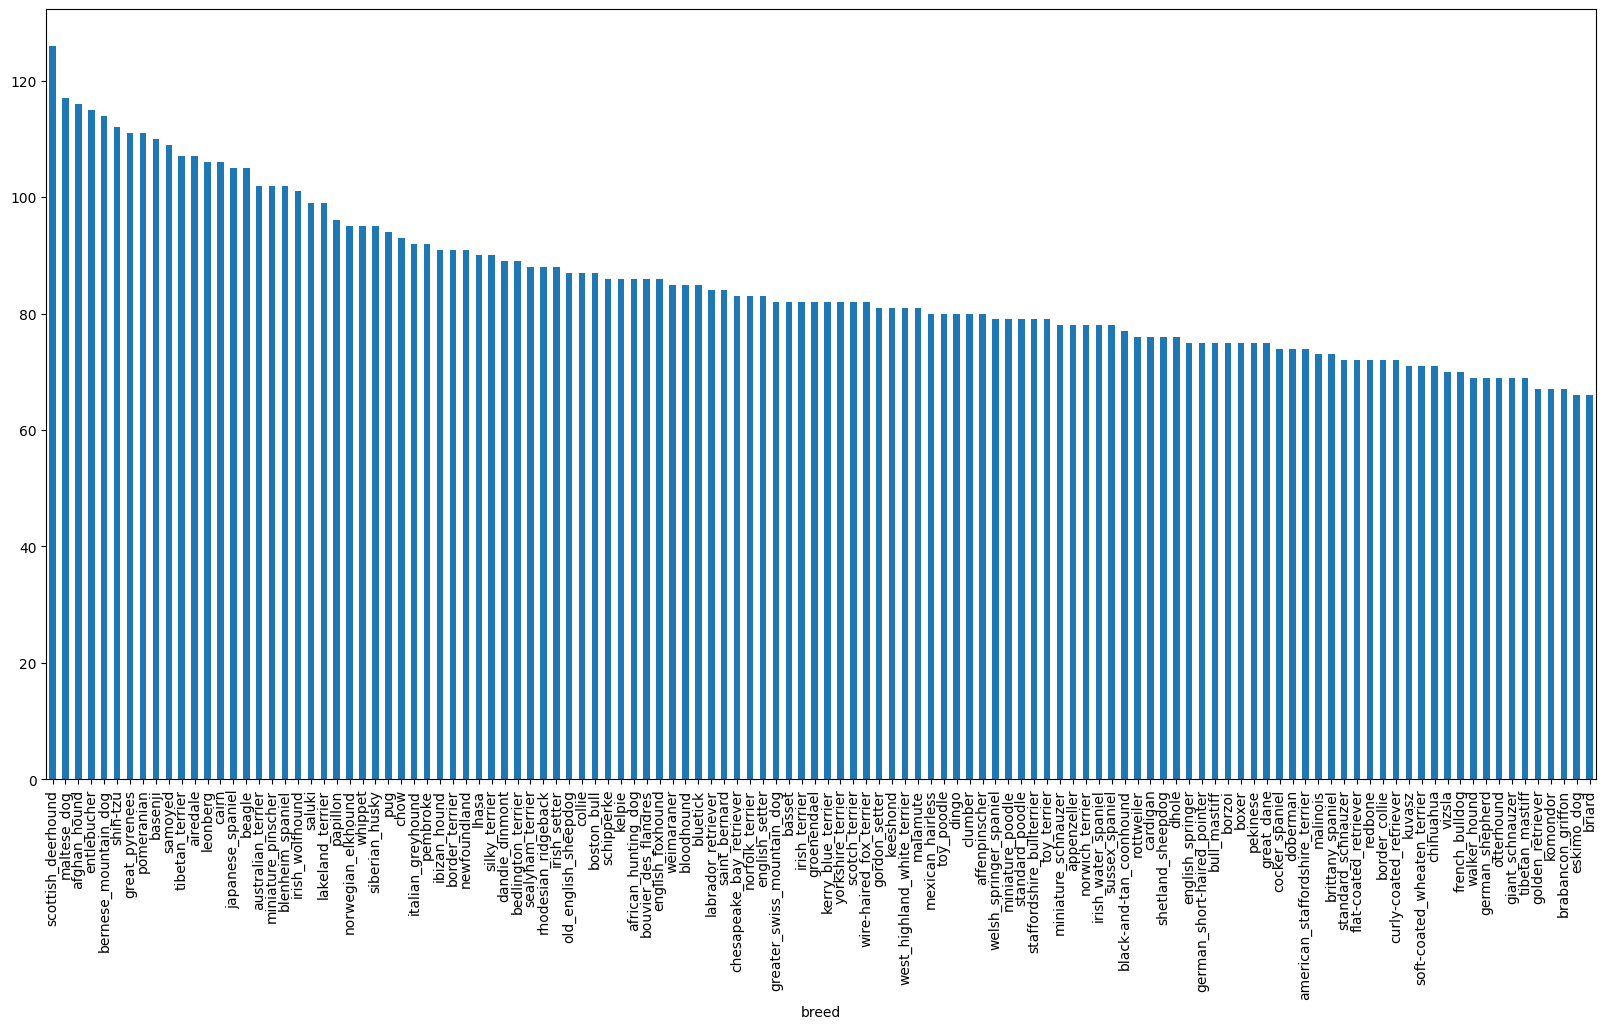

In [4]:
# check for dog classes
# labels_df["breed"].value_counts()
labels_df["breed"].value_counts().plot.bar(figsize=(20,10))

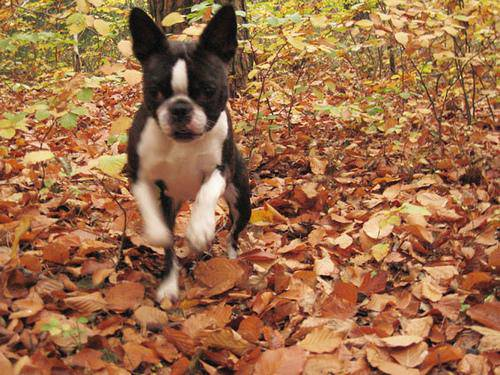

In [5]:
# view an image
from IPython.display import Image
Image("drive/MyDrive/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

## Let's get the list of all image-pathnames.

In [6]:
# create pathnames from image id's

filenames = ["drive/MyDrive/dog-breed-identification/train/" + fname + ".jpg" for fname in labels_df["id"]]
len(filenames)

10222

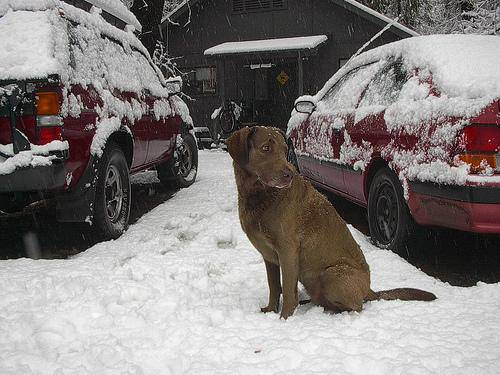

In [7]:
# check if the number of filenames matches the actual files
import os

# if len(os.listdir("drive/MyDrive/dog-breed-identification/train/")) == len(filenames):
#   print('tada')
# else:
#   print('no no')

Image(filenames[10221])


In [8]:
labels_df['breed'][10221]

'chesapeake_bay_retriever'

In [9]:
import numpy as np

labels = labels_df["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [10]:
# check if number of labels matches number of filenames

if len(labels) == len(filenames):
  print("the numbers match")
else:
  print("the numbers don't match up")

the numbers match


In [11]:
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [12]:
# turn a label into boolean array

# labels[0] = labels[0] == unique_breeds
# labels[0]

In [14]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]
len(boolean_labels)

10222

## Creating our validation set

In [52]:
# set up X and y variables
X = filenames
y = boolean_labels
len(X), len(y)

(10222, 10222)

We're going to start experimenting with ~1000 images and then increase as we go.

In [53]:
NUM_IMAGES = 1000

# let's split our data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [54]:
X_train[:1], y_train[:1]

(['drive/MyDrive/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, Fals

## Preprocessing images ( turning images into tensors )

We're going to write a function to convert image into tensors.

1. Take an image filepath as an input
2. Use tensorflow to read the file and save it into variable `image`
3. Turn the image to tensors
4. Resize the image to fixed shape (224, 224)
5. Return processed image

In [55]:
import tensorflow as tf

def load_image_to_tensor(file_path, image_size=(224, 224), normalize=True):
    image = tf.io.read_file(file_path)

    # ✅ Use a specific decoder
    image = tf.image.decode_jpeg(image, channels=3)

    image = tf.image.resize(image, image_size)

    if normalize:
        image = tf.image.convert_image_dtype(image, tf.float32)

    return image

## Turning our data into batches

In order to use tensorflow effectively, we need our data in the form of tensor tuples which looks like this `(image, label)`.
`32` is the standard batch size.

In [56]:
# create a function to return a tuple (image, label)

def image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = load_image_to_tensor(image_path)
  return (image, label)

In [61]:
# Define batch size
BATCH_SIZE = 32

# create function to return batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """

  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(map_func=load_image_to_tensor).batch(BATCH_SIZE)
    return data_batch

  if valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(map_func=image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(map_func=image_label).batch(BATCH_SIZE)
    return data_batch

In [65]:
# create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

train_data.element_spec

Creating training data batches...
Creating validation data batches...


(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))